In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import spikeinterface.full as si
from probeinterface import read_probeinterface
from probeinterface.plotting import plot_probe

%matplotlib widget

Matplotlib created a temporary cache directory at /tmp/matplotlib-79adx3ew because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# Main working directory
base_folder = Path.home() / 'RANCZLAB-NAS' / 'iakov' / 'data' / 'sid_715093703_pid_810755797'

# Input data
binary_filename = 'spike_band.dat'

# # Output sorting
# output_folder = base_folder / 'kilosort3_sorting_files'
# sorting_save_path = base_folder / 'kilosort3_sorting_output'

backend = 'ipywidgets'

https://eu-north-1.console.aws.amazon.com/s3/object/allen-brain-observatory?region=us-west-2&prefix=visual-coding-neuropixels/raw-data/715093703/810755797/spike_band.dat

Amazon S3 /
Buckets /
allen-brain-observatory /
visual-coding-neuropixels /
raw-data /
715093703 /
810755797 /
spike_band.dat


In [4]:
sampling_frequency = 29999.954846
dtype = np.int16
channel_number = 384

In [56]:
recordings = {}
recordings['raw'] = si.read_binary(base_folder / binary_filename, sampling_frequency=sampling_frequency, dtype=dtype, num_chan=channel_number)

In [57]:
recordings['raw']

BinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 257,175,972 samples 
                          8,572.55s (2.38 hours) - int16 dtype - 183.95 GiB
  file_paths: ['/home/jupyter-ikharitonov/RANCZLAB-NAS/iakov/data/sid_715093703_pid_810755797/spike_band.dat']

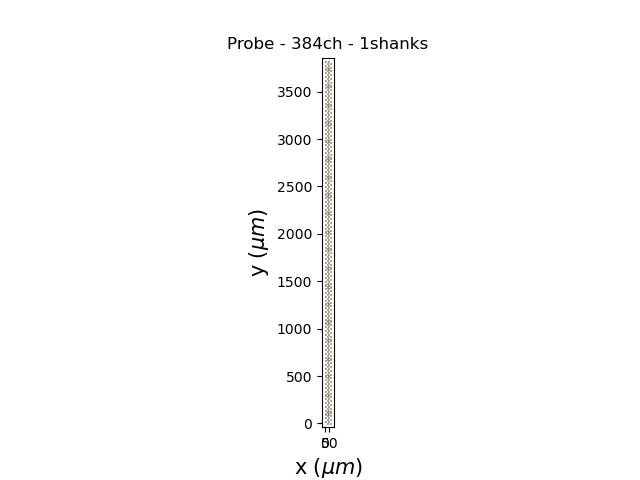

In [49]:
probegroup = read_probeinterface('../../pipeline/np_json_files/np1.json')
probe = probegroup.probes[0]
recordings['raw'] = recordings['raw'].set_probe(probe)

plot_probe(probe)
plt.show()

In [11]:
# https://spikeinterface.readthedocs.io/en/stable/modules/preprocessing.html#ibl-destripe
# https://github.com/int-brain-lab/ibl-neuropixel

In [42]:
# Taken from https://github.com/int-brain-lab/ibl-neuropixel/blob/main/src/neuropixel.py#L146
def adc_shifts(version=1, nc=384):
    """
    Neuropixel NP1
    The sampling is serial within the same ADC, but it happens at the same time in all ADCs.
    The ADC to channel mapping is done per odd and even channels:
    ADC1: ch1, ch3, ch5, ch7...
    ADC2: ch2, ch4, ch6....
    ADC3: ch33, ch35, ch37...
    ADC4: ch34, ch36, ch38...
    Therefore, channels 1, 2, 33, 34 get sample at the same time. I hope this is more or
    less clear. In 1.0, it is similar, but there we have 32 ADC that sample each 12 channels."
    - Nick on Slack after talking to Carolina - ;-)

    There are 384 channels (each with AP and LFP) divided into 32 groups (each group containing 1 ADC)
    The ADC cycle is at 30kHz * 13 = 360 kHz (hence the 13 cycles per AP sample).
    The ADC (from what I understand) goes like this : AP1-AP2-AP3-...-AP11-AP12-LF1-AP1-AP2-...-AP12-LF2-AP1-...
    A. Wyngaard

    For NP2 there are 16 cycles

    The probe always records from all 384 channels; you can disable sites, but they actually still get read back.
    The sample time shifts are always the same for a given channel -- each channel is hardwired to a specific
     ADC and has a specific order in the sampling lineup. So you should always calculate
      the sample shift based on the original channel number. In the SpikeGLX metadata,
      these are listed in the snsSaveChannelSubset field.

    :param version: neuropixel major version 1 or 2
    :param nc: number of channels
    """
    if version == 1:
        adc_channels = 12
        n_cycles = 13
        # version 1 uses 32 ADC that sample 12 channels each
    elif np.floor(version) == 2:
        # version 2 uses 24 ADC that sample 16 channels each
        adc_channels = n_cycles = 16
    adc = np.floor(np.arange(nc) / (adc_channels * 2)) * 2 + np.mod(np.arange(nc), 2)
    sample_shift = np.zeros_like(adc)
    for a in adc:
        sample_shift[adc == a] = np.arange(adc_channels) / n_cycles
    return sample_shift[:nc], adc[:nc]

In [43]:
# # preprocess
# recordings['1_phase_shift'] = si.phase_shift(recordings['raw'], inter_sample_shift=adc_shifts()[0])
# recordings['2_centred'] = si.center(recordings['1_phase_shift'], mode='median')
# # recordings['3_bandpass'] = si.bandpass_filter(recordings['2_centred'], freq_min=150, freq_max=9000)
# recordings['3_common_median'] = si.common_reference(recordings['2_centred'], reference='global', operator='median')
# recordings['4_highpass'] = si.highpass_filter(recordings['3_common_median'], freq_min=150)
# # recordings['5_highpass_spatial_filter'] = si.highpass_spatial_filter(recordings['4_highpass'])
# recordings['5_whitened'] = si.whiten(recordings['4_highpass'])

In [59]:
recordings['1'] = si.phase_shift(recordings['raw'], inter_sample_shift=adc_shifts()[0])
recordings['2'] = si.center(recordings['1'], mode='median')
recordings['3'] = si.highpass_filter(recordings['2'], freq_min=150)
recordings['4'] = si.common_reference(recordings['3'], reference='global', operator='median')
recordings['5'] = si.whiten(recordings['4'])

In [61]:
# plot
si.plot_traces(recordings, mode='map', time_range=[0, 0.1], backend=backend, height_cm=25, width_cm=60, clim=(-4, 4))

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

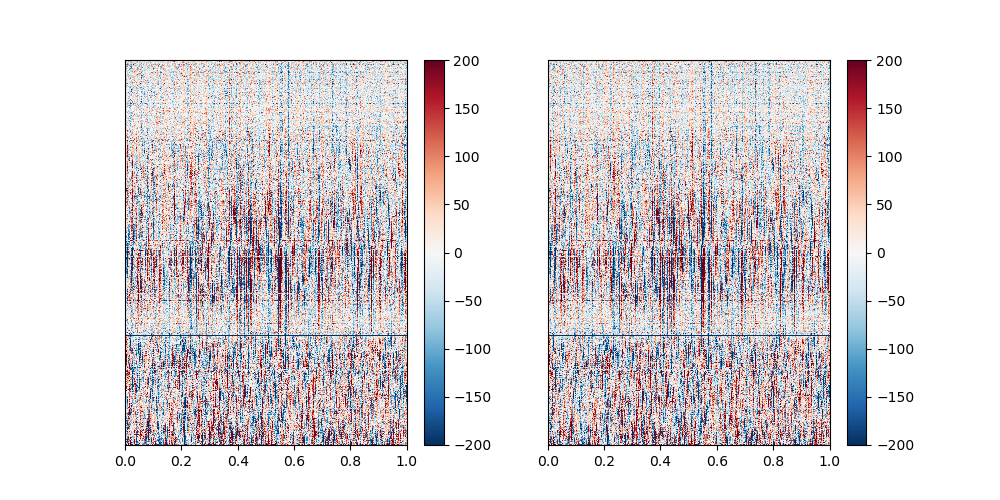

In [45]:
# si.plot_traces(recordings, mode='map', time_range=[0, 0.1], backend=backend, height_cm=25, width_cm=60)
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
si.plot_traces(recordings['raw'], backend='matplotlib', ax=axs[0])
si.plot_traces(recordings['1_phase_shift'], backend='matplotlib', ax=axs[1])

In [46]:
recordings.keys()

dict_keys(['raw', '1_phase_shift', '2_centred', '3_common_median', '4_highpass', '5_whitened'])

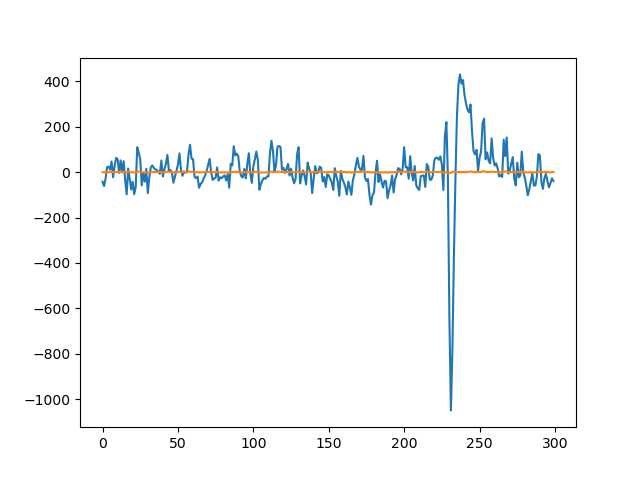

In [55]:
plt.figure()
plt.plot(recordings['4_highpass'].get_traces(channel_ids=[150], start_frame=int(0.04*sampling_frequency), end_frame=int(0.05*sampling_frequency)))
plt.plot(recordings['5_whitened'].get_traces(channel_ids=[150], start_frame=int(0.04*sampling_frequency), end_frame=int(0.05*sampling_frequency)))

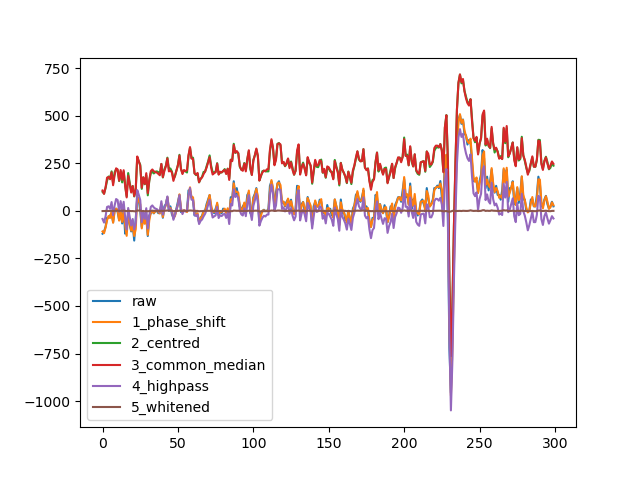

In [47]:
plt.figure()
for k in recordings.keys():
    plt.plot(recordings[k].get_traces(channel_ids=[150], start_frame=int(0.04*sampling_frequency), end_frame=int(0.05*sampling_frequency)))
# plt.plot(recordings['1_phase_shift'].get_traces(channel_ids=[150], start_frame=int(0.04*sampling_frequency), end_frame=int(0.05*sampling_frequency)))
# plt.plot(recordings['2_centred'].get_traces(channel_ids=[150], start_frame=int(0.04*sampling_frequency), end_frame=int(0.05*sampling_frequency)))
# plt.plot(recordings['3_bandpass'].get_traces(channel_ids=[150], start_frame=int(0.04*sampling_frequency), end_frame=int(0.05*sampling_frequency)))
# plt.plot(recordings['4_common_median'].get_traces(channel_ids=[150], start_frame=int(0.04*sampling_frequency), end_frame=int(0.05*sampling_frequency)))
# plt.plot(recordings['5_highpass_spatial_filter'].get_traces(channel_ids=[150], start_frame=int(0.04*sampling_frequency), end_frame=int(0.05*sampling_frequency)))

plt.legend(recordings.keys())

In [29]:
parameter_dict = si.get_default_sorter_params('kilosort2')
parameter_dict

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'freq_min': 150,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'AUCsplit': 0.9,
 'wave_length': 61,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None,
 'save_rez_to_mat': False,
 'delete_tmp_files': True,
 'delete_recording_dat': False,
 'n_jobs': 36,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

In [30]:
si.get_sorter_description('kilosort2')

'Kilosort2 is a GPU-accelerated and efficient template-matching spike sorter. On top of its\n    predecessor Kilosort, it implements a drift-correction strategy.\n    For more information see https://github.com/MouseLand/Kilosort2'

In [31]:
si.get_sorter_params_description('kilosort2')

{'detect_threshold': 'Threshold for spike detection',
 'projection_threshold': 'Threshold on projections',
 'preclust_threshold': 'Threshold crossings for pre-clustering (in PCA projection space)',
 'car': 'Enable or disable common reference',
 'minFR': 'Minimum spike rate (Hz), if a cluster falls below this for too long it gets removed',
 'minfr_goodchannels': "Minimum firing rate on a 'good' channel",
 'freq_min': 'High-pass filter cutoff frequency',
 'sigmaMask': 'Spatial constant in um for computing residual variance of spike',
 'nPCs': 'Number of PCA dimensions',
 'ntbuff': 'Samples of symmetrical buffer for whitening and spike detection',
 'nfilt_factor': 'Max number of clusters per good channel (even temporary ones) 4',
 'NT': 'Batch size (if None it is automatically computed)',
 'AUCsplit': 'Threshold on the area under the curve (AUC) criterion for performing a split in the final step',
 'wave_length': 'size of the waveform extracted around each detected peak, (Default 61, maxi

In [32]:
parameter_dict['projection_threshold'] = [10, 4]
parameter_dict['freq_min'] = 150
parameter_dict['minfr_goodchannels'] = 0.1
# parameter_dict['lam'] = 10
parameter_dict['AUCsplit'] = 0.9
parameter_dict['minFR'] = 1/50
# parameter_dict['momentum'] = [20, 400]
parameter_dict['sigmaMask'] = 30
parameter_dict['preclust_threshold'] = 8
parameter_dict['skip_kilosort_preprocessing'] = True

parameter_dict['n_jobs'] = -1

In [63]:
parameter_dict

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.02,
 'minfr_goodchannels': 0.1,
 'freq_min': 150,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'AUCsplit': 0.9,
 'wave_length': 61,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': True,
 'scaleproc': None,
 'save_rez_to_mat': False,
 'delete_tmp_files': True,
 'delete_recording_dat': False,
 'n_jobs': -1,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

In [24]:
sorter_name = 'kilosort2'
sorter_path = Path.home() / 'RANCZLAB-NAS' / 'spikesorter_images' / 'kilosort2-compiled-base.sif'

In [ ]:
sorting = si.run_sorter(sorter_name, recording=recordings['common_median'], output_folder=Path.home()/'RANCZLAB-NAS/iakov/allen_sorting_ks2_13_dec', singularity_image=sorter_path, verbose=True, **parameter_dict)

Starting container
Installing spikeinterface from sources in /home/jupyter-ikharitonov/RANCZLAB-NAS/spikesorter_images/kilosort2-compiled-base.sif
Installing dev spikeinterface from remote repository
Running kilosort2 sorter inside /home/jupyter-ikharitonov/RANCZLAB-NAS/spikesorter_images/kilosort2-compiled-base.sif
